# Doggo Brain Check


In [1]:
#Import packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#URL to csvs
breed_info_url="https://raw.githubusercontent.com/OtterBots/DoggieData/main/AKC_Breed_Info.csv"
intel_url = "https://raw.githubusercontent.com/OtterBots/DoggieData/main/dog_intelligence.csv"

In [3]:
#Import data
df1 = pd.read_csv(breed_info_url)
df2 = pd.read_csv(intel_url)

## _Pre-Process data_

- Joing dataframes
- Drop rows that dont have an entry in both tables
- Convert string value to useable numbers
- The lowest inteligence levels dont have an obey value so assume 0

***There is one row Alaskan Malamute which has na for physical dimensions. Currently we fill to 0 but the data seems like it will negatively affect our invesitgation. Need to investigate***

In [16]:
#merge
dd=pd.merge(df1,df2, on='Breed')

#drop old index
dd.drop('index_x', axis=1,inplace=True)
dd.drop('index_y', axis=1,inplace=True)

#fill nan for dummies
dd['obey'].fillna('0%', inplace=True)

#convert obey to int
def obeyToInt(x):
    str(x)
    return int(x.replace('%',''))
dd['obey'] = dd['obey'].apply(obeyToInt)

#convert dimension collumns to float. Replace na with 0
def dimension(x):
    str(x)
    if x == 'na':
        return 0
    else:
        return float(x)

dd['height_low_inches'] = dd['height_low_inches'].apply(dimension)
dd['height_high_inches'] = dd['height_high_inches'].apply(dimension)
dd['weight_low_lbs'] = dd['weight_low_lbs'].apply(dimension)
dd['weight_high_lbs'] = dd['weight_high_lbs'].apply(dimension)

- Average all the number columns 

In [17]:
#add averages
dd['weight_avg'] = (dd['weight_high_lbs']+dd['weight_low_lbs'])/2
dd['height_avg'] = (dd['height_high_inches']+dd['height_low_inches'])/2
dd['reps_avg'] = (dd['reps_lower']+dd['reps_upper'])/2

## _Data Exploration plots_

### .................. DREW .....................

Text(0.5, 1.0, 'smarts vs average_weight')

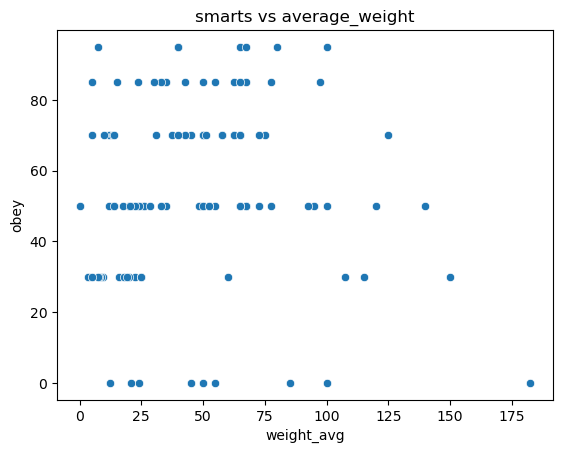

In [22]:
sns.scatterplot(data=dd, y='obey', x='weight_avg')
plt.title('smarts vs average_weight')

Text(0.5, 1.0, 'Dog Fatness and Intellect Classification')

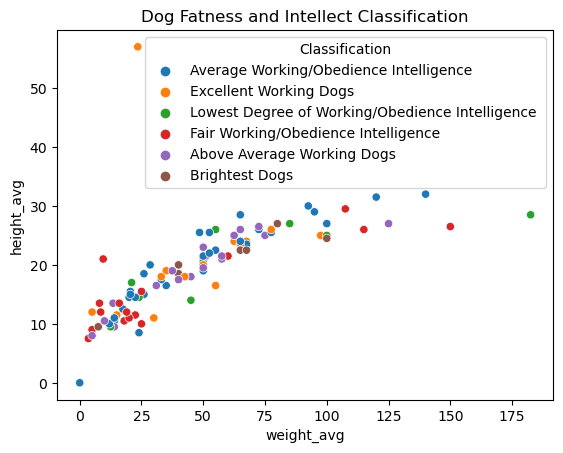

In [27]:
sns.scatterplot(data=dd, x='weight_avg', y='height_avg', hue='Classification')
plt.title('Dog Fatness and Intellect Classification')

## Investigate distribution

In [64]:
pd.options.display.max_rows = 250
(dd[['Classification', 'obey', 'reps_avg']].drop_duplicates()).sort_values(by='obey')

,Classification,obey,reps_avg
2,Lowest Degree of Working/Obedience Intelligence,0,90.5
4,Fair Working/Obedience Intelligence,30,60.5
0,Average Working/Obedience Intelligence,50,33.0
10,Above Average Working Dogs,70,20.5
1,Excellent Working Dogs,85,10.0
11,Brightest Dogs,95,2.5


Text(0.5, 1.0, 'Classification Distribution')

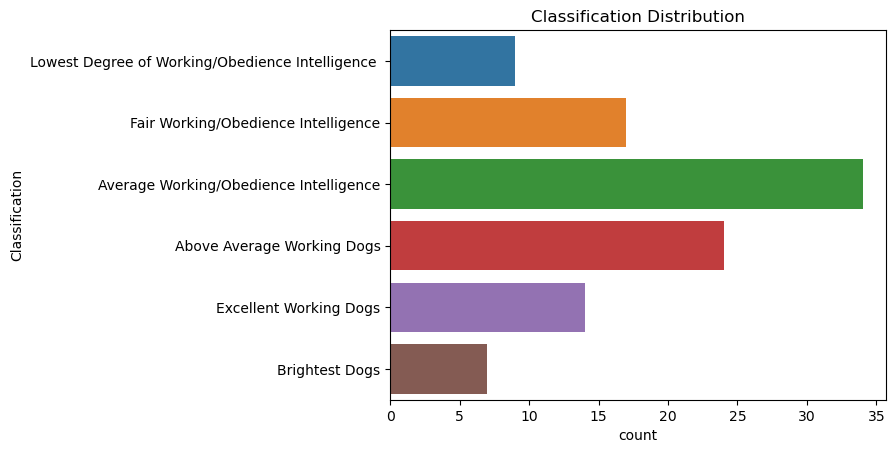

In [65]:

sns.countplot(y=dd.sort_values(by='obey')['Classification'])
plt.title('Classification Distribution')

### .................. JULI .....................

### .................. NADZ .....................

### .................. KEV .....................